# A6.2 Tic Tac Toe

For this assignment you will run a number of comparisons between different neural networks trained through Q-learning to predict Q functions for Player X and for Player O in a simple Tic Tac Toe game.  

All but one simple function is provided, so your effort will be in choosing the parameters for the experiments.

In [ ]:
%%writefile optimizers.py
import numpy as np

######################################################################
## class Optimizers()
######################################################################

class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights

        # The following initializations are only used by adam.
        # Only initializing m, v, beta1t and beta2t here allows multiple calls to adam to handle training
        # with multiple subsets (batches) of training data.
        self.mt = np.zeros_like(all_weights)
        self.vt = np.zeros_like(all_weights)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.beta1t = 1
        self.beta2t = 1

        
    def sgd(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=True, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= learning_rate * grad

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'sgd: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

    def adam(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, verbose=True, error_convert_f=None):
        '''
error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
            with respect to each weight.
error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            self.mt[:] = self.beta1 * self.mt + (1 - self.beta1) * grad
            self.vt[:] = self.beta2 * self.vt + (1 - self.beta2) * grad * grad
            self.beta1t *= self.beta1
            self.beta2t *= self.beta2

            m_hat = self.mt / (1 - self.beta1t)
            v_hat = self.vt / (1 - self.beta2t)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= alpha * m_hat / (np.sqrt(v_hat) + epsilon)
    
            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'Adam: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

if __name__ == '__main__':

    import matplotlib.pyplot as plt
    plt.ion()

    def parabola(wmin):
        return ((w - wmin) ** 2)[0]

    def parabola_gradient(wmin):
        return 2 * (w - wmin)

    w = np.array([0.0])
    optimizer = Optimizers(w)

    wmin = 5
    optimizer.sgd(parabola, parabola_gradient, [wmin],
                  n_epochs=500, learning_rate=0.1)

    print(f'sgd: Minimum of parabola is at {wmin}. Value found is {w}')

    w = np.array([0.0])
    optimizer = Optimizers(w)
    optimizer.adam(parabola, parabola_gradient, [wmin],
                   n_epochs=500, learning_rate=0.1)
    
    print(f'adam: Minimum of parabola is at {wmin}. Value found is {w}')

Writing optimizers.py


In [ ]:
%%writefile neuralnetworks.py
import numpy as np
import optimizers
import sys  # for sys.float_info.epsilon

######################################################################
## class NeuralNetwork()
######################################################################

class NeuralNetwork():


    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function='tanh'):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.activation_function = activation_function

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'{type(self).__name__}({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs}, \'{self.activation_function}\')'


    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        result = self.__repr__()
        if len(self.error_trace) > 0:
            return self.__repr__() + f' trained for {len(self.error_trace)} epochs, final training error {self.error_trace[-1]:.4f}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd', verbose=True):
        '''
train: 
  X: n_samples x n_inputs matrix of input samples, one per row
  T: n_samples x n_outputs matrix of target output values, one sample per row
  n_epochs: number of passes to take through all samples updating weights each pass
  learning_rate: factor controlling the step size of each update
  method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = optimizers.Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units, 
        # but only if the network has a single output. Multiplying by self.Tstds for 
        # multiple outputs does not correctly unstandardize the error.
        if len(self.Tstds) == 1:
            error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar
        else:
            error_convert_f = lambda err: np.sqrt(err)[0] # to scalar
            

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        verbose=False,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         verbose=False,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self

    def relu(self, s):
        s[s < 0] = 0
        return s

    def grad_relu(self, s):
        return (s > 0).astype(int)
    
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        for W in self.Ws[:-1]:
            if self.activation_function == 'relu':
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            else:
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            if self.activation_function == 'relu':
                delta = delta @ self.Ws[layeri][1:, :].T * self.grad_relu(self.Ys[layeri])
            else:
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

    def use(self, X):
        '''X assumed to not be standardized'''
        # Standardize X
        X = (X - self.Xmeans) / self.Xstds
        Ys = self.forward_pass(X)
        Y = Ys[-1]
        # Unstandardize output Y before returning it
        return Y * self.Tstds + self.Tmeans

Writing neuralnetworks.py


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import neuralnetworks as nn

In [ ]:
def initial_state():
    return np.array([0] * 9)

def next_state(s, a, marker):  # s is a board, and a is an index into the cells of the board, marker is 1 or -1
    s = s.copy()
    s[a] = 1 if marker == 'X' else -1
    return s

def reinforcement(s):
    if won('X', s):
        return 1
    if won('O', s):
        return -1
    return 0

def won(player, s):
    marker = 1 if player == 'X' else -1
    combos = np.array((0,1,2, 3,4,5, 6,7,8, 0,3,6, 1,4,7, 2,5,8, 0,4,8, 2,4,6))
    return np.any(np.all(marker == s[combos].reshape((-1, 3)), axis=1))

def draw(s):
    return sum(s == 0) == 0

def valid_actions(state):
    return np.where(state == 0)[0]

In [ ]:
def stack_sa(s, a):
    return np.hstack((s, a)).reshape(1, -1)

def other_player(player):
    return 'X' if player == 'O' else 'O'

In [ ]:
def epsilon_greedy(Qnet, state, epsilon):
    
    actions = valid_actions(state)
    
    if np.random.uniform() < epsilon:
        # Random Move
        action = np.random.choice(actions)
        
    else:
        # Greedy Move
        np.random.shuffle(actions)
        Qs = np.array([Qnet.use(stack_sa(state, a)) for a in actions])
        action = actions[np.argmax(Qs)]
        
    return action

In [ ]:
def make_samples(Qnets, initial_state_f, next_state_f, reinforcement_f, epsilon):
    '''Run one game'''
    Samples = {'X': {'SA': [], 'R': [], 'Qn': []},
               'O': {'SA': [], 'R': [], 'Qn': []}}

    s = initial_state_f()
    player = 'X'

    while True:
        
        a = epsilon_greedy(Qnets[player], s, epsilon)
        sn = next_state_f(s, a, player)
        r = reinforcement_f(sn)

        Samples[player]['SA'].append(stack_sa(s, a))
        Samples[player]['R'].append(r)   # r is with respect to X
        Samples[player]['Qn'].append(0.0)  # fill in layer

        if r != 0 or draw(sn):
            Samples[other_player(player)]['R'][-1] = r  
            break

        s = sn
        player = other_player(player)  # switch

    for player in ['X', 'O']:
        Samps = Samples[player]
        Samps['SA'] = np.vstack(Samps['SA'])
        Samps['R'] = np.array(Samps['R']).reshape(-1, 1)
        Samps['Qn'] =  np.array(Samps['Qn']).reshape(-1 ,1)  # this statement added in A6.1

    # Assign all Qn's, based on following state, but go every other state to do all X values,
    ends_with_O = len(Samples['X']) > len(Samples['O'])
    if ends_with_O:
        # O wins
        Samples['X']['Qn'][:-1] = Qnets['X'].use(Samples['X']['SA'][1:, :])
        Samples['O']['Qn'][:-1] = Qnets['O'].use(Samples['O']['SA'][1:])
    else:
        # X wins or draw
        Samples['X']['Qn'][:-1] = Qnets['X'].use(Samples['X']['SA'][1:])
        Samples['O']['Qn'][:-1] = Qnets['O'].use(Samples['O']['SA'][1:])

    for player in ['X', 'O']:
        Samps = Samples[player]
        Samps['Qn'] = np.array(Samps['Qn']).reshape(-1, 1)

    return Samples

In [ ]:
def plot_status(outcomes, epsilons, n_trials, trial):
    if trial == 0:
        return
    outcomes = np.array(outcomes)
    n_per = 10
    n_bins = (trial + 1) // n_per
    if n_bins == 0:
        return
    outcome_rows = outcomes[:n_per * n_bins].reshape((-1, n_per))
    outcome_rows = outcome_rows[:trial // n_per + 1, :]
    avgs = np.mean(outcome_rows, axis=1)
    
    plt.subplot(3, 1, 1)
    xs = np.linspace(n_per, n_per * n_bins, len(avgs))
    plt.plot(xs, avgs)
    plt.ylim(-1.1, 1.1)
    plt.xlabel('Games')
    plt.ylabel('Mean of Outcomes') # \n(0=draw, 1=X win, -1=O win)')
    plt.title(f'Bins of {n_per:d} Games')
    
    plt.subplot(3, 1, 2)
    plt.plot(xs, np.sum(outcome_rows == -1, axis=1), 'r-', label='Losses')
    plt.plot(xs, np.sum(outcome_rows == 0, axis=1), 'b-', label='Draws')
    plt.plot(xs, np.sum(outcome_rows == 1, axis=1), 'g-', label='Wins')
    plt.legend(loc='center')
    plt.ylabel(f'Number of Games\nin Bins of {n_per:d}')
    
    plt.subplot(3, 1, 3)
    plt.plot(epsilons[:trial])
    plt.ylabel('$\epsilon$')

In [ ]:
def setup_standardization(Qnet, Xmeans, Xstds, Tmeans, Tstds):
    Qnet.Xmeans = np.array(Xmeans)
    Qnet.Xstds = np.array(Xstds)
    Qnet.Tmeans = np.array(Tmeans)
    Qnet.Tstds = np.array(Tstds)

In [ ]:
from IPython.display import display, clear_output

def run(X_hidden_units_list_of_lists, O_hidden_units_list_of_lists, n_epochs_list, learning_rate_list, 
        repetitions=5, graphics=False):
    
    if graphics:
        fig = plt.figure(figsize=(10, 10))
        
    n_trials = 8000         # number of repetitions of makeSamples-updateQ loop
    
    gamma = 1.0        # discount factor
    final_epsilon = 0.01 # value of epsilon at end of simulation. Decay rate is calculated
    epsilon_decay = np.exp(np.log(final_epsilon) / (n_trials)) # to produce this final value

    results = []
    for n_epochs in n_epochs_list:
        for learning_rate in learning_rate_list:
            for X_nh in X_hidden_units_list_of_lists:
                for O_nh in O_hidden_units_list_of_lists:
                
                    last_fifth_outcomes = []

                    # RRn multiple experiments for these parameter values and average the results
                    for rep in range(repetitions):
                        
                        print(rep + 1, end=' ')
                        # Qnet for Player 'X'
                        QnetX = nn.NeuralNetwork(9 + 1, X_nh, 1)
                        # Qnet for Player 'O'
                        QnetO = nn.NeuralNetwork(9 + 1, O_nh, 1)
                        Qnets = {'X': QnetX, 'O': QnetO}

                        # Inputs are 9 TTT cells plus 1 action
                        setup_standardization(QnetX, [0] * 10, [1] * 10, [0], [1])
                        setup_standardization(QnetO, [0] * 10, [1] * 10, [0], [1])

                        epsilon = 1         # initial epsilon value
                        outcomes = []
                        epsilon_trace = []

                        # Train for n_trials
                        for trial in range(n_trials):

                            Samples = make_samples(Qnets, initial_state, next_state, reinforcement, epsilon)

                            Samps = Samples['X']
                            SA = Samps['SA']
                            R = Samps['R']
                            Qn = Samps['Qn']
                            T = R + gamma * Qn
                            Qnets['X'].train(SA, T, n_epochs, learning_rate, method='sgd', verbose=False)

                            Samps = Samples['O']
                            SA = Samps['SA']
                            R = - Samps['R']  # r is with respect to X, so negate it
                            Qn = Samps['Qn']
                            T = R + gamma * Qn
                            Qnets['O'].train(SA, T, n_epochs, learning_rate, method='sgd', verbose=False)

                            outcomes.append(Samples['X']['R'][-1])
                            epsilon_trace.append(epsilon)

                            epsilon *= epsilon_decay
                            
                            if graphics and (trial + 1 == n_trials or trial % (n_trials / 20) == 0):
                                plt.clf()
                                plot_status(outcomes, epsilon_trace, n_trials, trial)
                                clear_output(wait=True)
                                display(fig)

                        # For each repetition collect the mean of the outcome for the final fifth games
                        last_fifth_outcomes.append(np.mean(outcomes[-n_trials // 5:]))
                        print(f'{last_fifth_outcomes[-1]:.1f},', end=' ')
                        
                    results.append([X_nh, O_nh, n_epochs, learning_rate, np.mean(last_fifth_outcomes)])
                    print(results[-1])
                    
    if graphics:
        clear_output(wait=True)
        
    return pandas.DataFrame(results, columns=('X_nh', 'O_nh', 'n_epochs', 'lr', 'last_fifth_outcomes')), Qnets

Here is an example run with just one value for each of the four parameters.  Only 1 repetition will be performed.

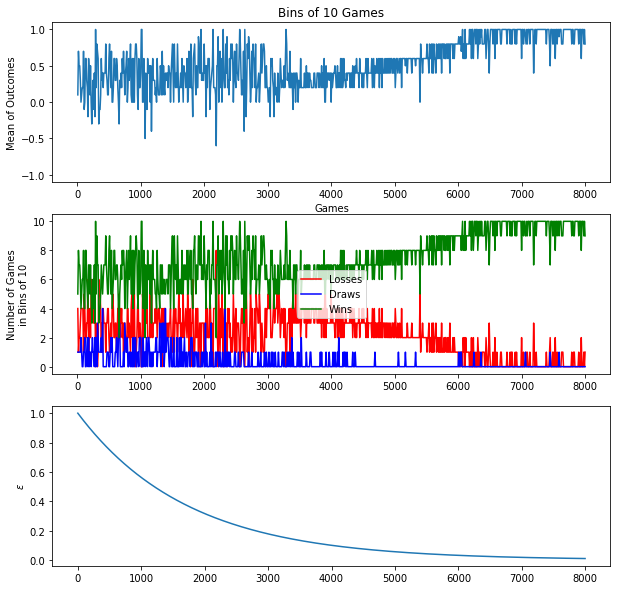

In [ ]:
result, Qnets = run([[]], [[100, 20]], [40], [0.001], 1, True)

In [ ]:
Qnets

{'O': NeuralNetwork(10, [100, 20], 1, 'tanh'),
 'X': NeuralNetwork(10, [], 1, 'tanh')}

In [ ]:
print(Qnets['X'])
print(Qnets['O'])

NeuralNetwork(10, [], 1, 'tanh') trained for 40 epochs, final training error 0.0206
NeuralNetwork(10, [100, 20], 1, 'tanh') trained for 40 epochs, final training error 0.0147


Change the following function to compare different neural network structures for X and for O and also try multiple values for `n_epochs` and `learning_rate`.  Include the results of running your function in this notebook.

Try at least three different network structures for each player and three different values for `n_epochs` and three different values for `learning_rate`.  Use at least 5 for the second to last argument so your results are averaged over 5 repetitions. Try to find parameters for which O consistently wins, and ones for which X consistently wins. Include these choices in the lists of parameter values in the following function.

Discuss your results.  Do they make sense?

Here is an example run, though you must use at least three values for each of the first four arguments.

In [ ]:
def myresult():
    result, Qnets = run(X_hidden_units_list_of_lists=[[10], [10, 10], [10,20,10]],
                        O_hidden_units_list_of_lists=[[10], [20,100,20], [100,20,100]],
                        n_epochs_list=[20,40,60],
                        learning_rate_list=[0.001,0.005,0.01], 
                        repetitions=5, graphics=False)
    return result

import time
start_time = time.time()

result = myresult()

print(f'Took {(time.time() - start_time) / 60.0:.1f} minutes.')

result

1 0.6, 2 1.0, 3 0.6, 4 0.7, 5 0.3, [[10], [10], 20, 0.001, 0.64025]
1 0.9, 2 1.0, 3 1.0, 4 1.0, 5 1.0, [[10], [20, 100, 20], 20, 0.001, 0.9574999999999999]
1 0.9, 2 1.0, 3 1.0, 4 1.0, 5 1.0, [[10], [100, 20, 100], 20, 0.001, 0.953125]
1 1.0, 2 0.7, 3 0.9, 4 0.6, 5 0.7, [[10, 10], [10], 20, 0.001, 0.78425]
1 1.0, 2 0.9, 3 0.9, 4 0.9, 5 1.0, [[10, 10], [20, 100, 20], 20, 0.001, 0.9395]
1 0.9, 2 0.9, 3 0.9, 4 1.0, 5 0.9, [[10, 10], [100, 20, 100], 20, 0.001, 0.9410000000000001]
1 0.5, 2 -0.1, 3 0.8, 4 -0.9, 5 0.1, [[10, 20, 10], [10], 20, 0.001, 0.06599999999999999]
1 0.9, 2 1.0, 3 0.9, 4 0.9, 5 0.9, [[10, 20, 10], [20, 100, 20], 20, 0.001, 0.9436249999999999]
1 0.9, 2 0.9, 3 0.9, 4 0.9, 5 0.9, [[10, 20, 10], [100, 20, 100], 20, 0.001, 0.9440000000000002]
1 0.8, 2 0.9, 3 0.7, 4 0.9, 5 0.5, [[10], [10], 20, 0.005, 0.7536250000000001]
1 1.0, 2 1.0, 3 1.0, 4 1.0, 5 1.0, [[10], [20, 100, 20], 20, 0.005, 0.9776250000000001]
1 1.0, 2 1.0, 3 1.0, 4 1.0, 5 1.0, [[10], [100, 20, 100], 20, 0.005, 0

,X_nh,O_nh,n_epochs,lr,last_fifth_outcomes
0,[10],[10],20,0.001,0.640250
1,[10],"[20, 100, 20]",20,0.001,0.957500
2,[10],"[100, 20, 100]",20,0.001,0.953125
3,"[10, 10]",[10],20,0.001,0.784250
4,"[10, 10]","[20, 100, 20]",20,0.001,0.939500
...,...,...,...,...,...
76,"[10, 10]","[20, 100, 20]",60,0.010,0.926250
77,"[10, 10]","[100, 20, 100]",60,0.010,0.943125
78,"[10, 20, 10]",[10],60,0.010,0.576375
79,"[10, 20, 10]","[20, 100, 20]",60,0.010,0.752000


From my runs X won consistantly for almost every match up. This is to be expected because X has a major advantage by going first. the one case were O was close was the [10, 20, 10]X vs [10]O with 20 epochs and a learing rate of .001; and even here X still sightly won. I this case the reason that O did so much better that average was due to the fact that X had a much larger network to train on a low number of epochs and a small learning rate. In all other match ups with the same networks shape, but with either a larger learning rate or higher number of epochs X consistantly won. 

## Extra Credit

For 1 point of extra credit do the following steps.

1. Call `run` using your best parameter values and for 1 repetition.
2. Create four boards for which it is `X`'s turn. Using the returned `Qnets` print a display of the Q values generated by `Qnets['X']` in a 3 x 3 table corresponding to the tic tac toe board, for each of these four boards.
3. Create four boards for which it is `O`'s turn. Using the returned `Qnets` print a display of the Q values generated by `Qnets['O']` in a 3 x 3 table corresponding to the tic tac toe board, for these four boards.
4. Discuss the values.  Do they make sense?